In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
data = pd.read_csv('marketing_customer_analysis.csv')
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [3]:
data.columns

Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_data = data.select_dtypes(include=[np.number])

# Identify and drop highly correlated features to avoid multicollinearity
correlation_matrix = numeric_data.corr()
correlation_threshold = 0.7
to_drop = [col for col in correlation_matrix.columns if any(correlation_matrix[col].abs() > correlation_threshold)]
numeric_data = numeric_data.drop(columns=to_drop)


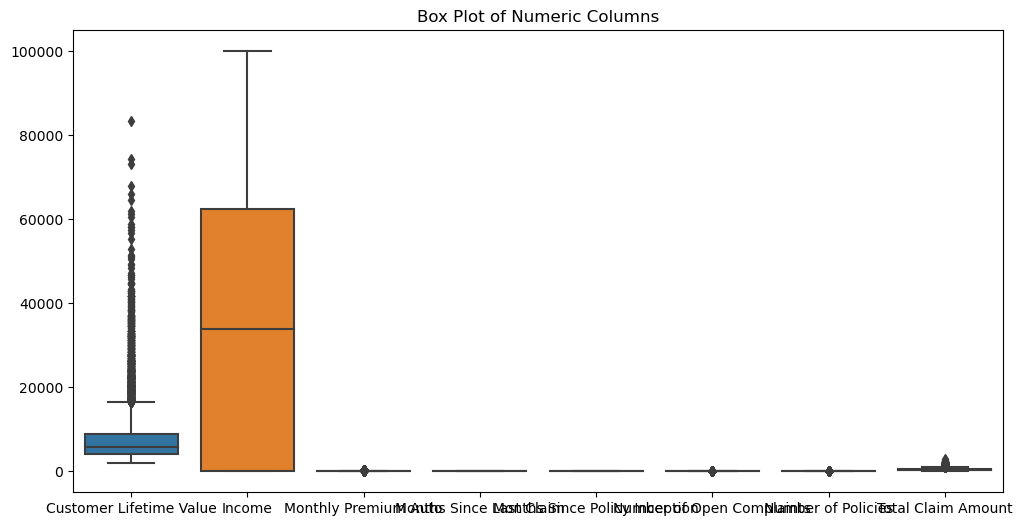

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_data = data.select_dtypes(include=[np.number])

#box plot for each numeric column
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_data)
plt.title("Box Plot of Numeric Columns")
plt.show()

In [6]:
from scipy.stats import zscore

# Calculate Z-scores for all numeric columns
z_scores = np.abs(zscore(numeric_data))

# Set a threshold for Z-scores (e.g., 3 standard deviations)
threshold = 3
outliers_mask = (z_scores > threshold).any(axis=1)

# Remove outliers
data_cleaned = data[~outliers_mask]

# Display the shape before and after outlier removal
print("Shape before removing outliers:", data.shape)
print("Shape after removing outliers:", data_cleaned.shape)


Shape before removing outliers: (9134, 24)
Shape after removing outliers: (8470, 24)


In [7]:
from sklearn.model_selection import train_test_split

# X-y split (assuming 'Total Claim Amount' is the target variable)
X = data_cleaned.drop(columns=['Total Claim Amount'])
y = data_cleaned['Total Claim Amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)


In [8]:
from sklearn.preprocessing import StandardScaler

# Split X_train into numerical and categorical
numerical_columns = X_train_df.select_dtypes(include=np.number).columns
categorical_columns = X_train_df.select_dtypes(exclude=np.number).columns

X_train_numerical = X_train_df[numerical_columns]
X_train_categorical = X_train_df[categorical_columns]

# If needed, apply transformations to numerical columns (example using StandardScaler)
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)

# Transform X_test using the same scaler
X_test_numerical = X_test_df[numerical_columns]
X_test_numerical_scaled = scaler.transform(X_test_numerical)

# Create DataFrames with transformed numerical columns
X_train_transformed = pd.DataFrame(X_train_numerical_scaled, columns=numerical_columns)
X_test_transformed = pd.DataFrame(X_test_numerical_scaled, columns=numerical_columns)


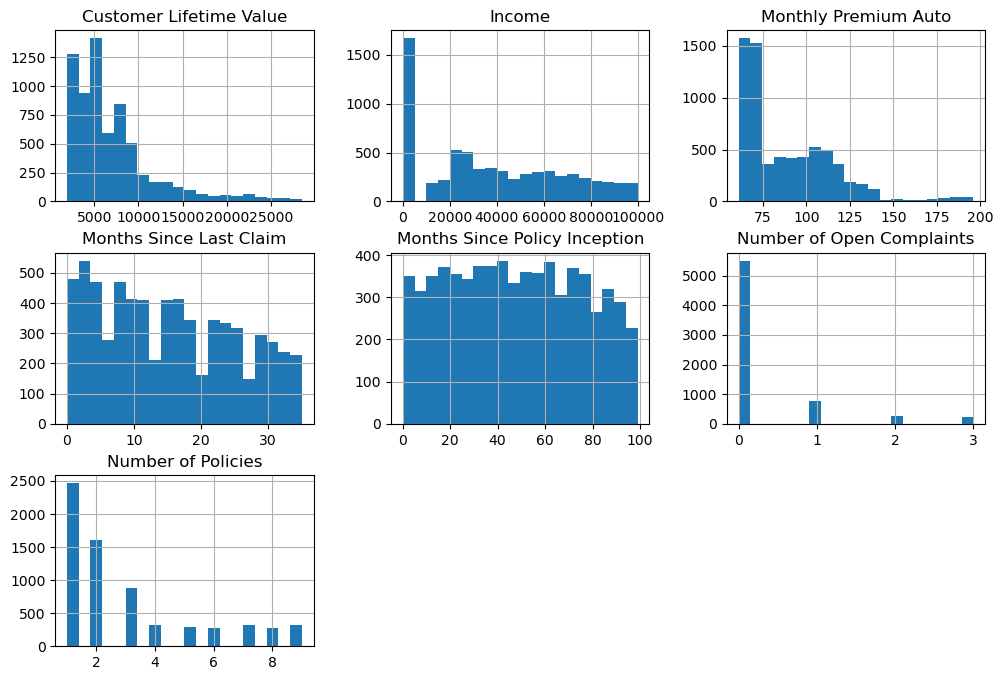

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

#histograms for numerical features in the trainng set
X_train_df[numerical_columns].hist(bins=20, figsize=(12, 8))
plt.show()


In [10]:
#observing the features have skewed distributions, so we need to apply transformations.

In [11]:
summary_statistics = X_train_df[numerical_columns].describe()
print(summary_statistics)


       Customer Lifetime Value        Income  Monthly Premium Auto  \
count              6776.000000   6776.000000           6776.000000   
mean               7151.122609  37980.072166             88.813312   
std                4874.944018  30354.950239             26.026376   
min                1898.007675      0.000000             61.000000   
25%                3886.242705  10621.000000             68.000000   
50%                5600.082522  34337.000000             80.000000   
75%                8569.937157  62473.250000            106.000000   
max               28511.033310  99981.000000            196.000000   

       Months Since Last Claim  Months Since Policy Inception  \
count              6776.000000                    6776.000000   
mean                 15.094303                      47.716499   
std                  10.084139                      27.877434   
min                   0.000000                       0.000000   
25%                   6.000000              

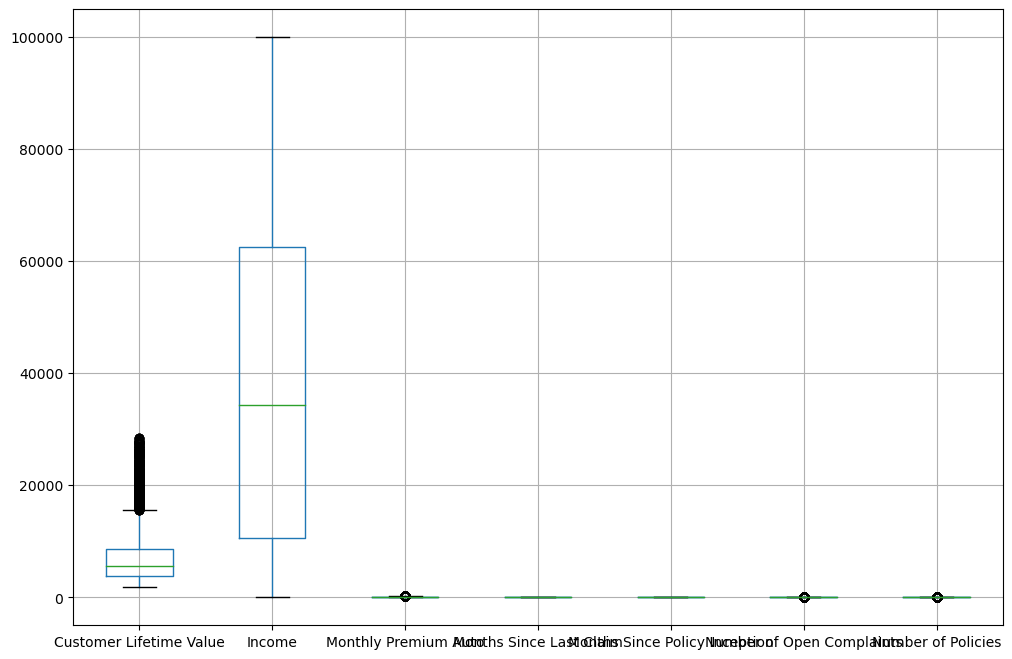

In [12]:
#Checking for outliers after 1st round removing. 
X_train_df[numerical_columns].boxplot(figsize=(12, 8))
plt.show()


In [13]:
#Saving all the transofrmaers scalers after the.fit() using pickle
import os
import pickle

# Create a directory to store transformers/scalers
path = "transformers/"
if not os.path.exists(path):
    os.makedirs(path)
    print("The new directory is created!")

# Save the scaler using pickle
filename = "scaler.pkl"  # Choose a descriptive name
with open(path + filename, "wb") as file:
    pickle.dump(scaler, file)

print(f"Scaler saved successfully as {filename} in {path}")

Scaler saved successfully as scaler.pkl in transformers/


In [14]:
with open(path + filename, "rb") as file:
    loaded_scaler = pickle.load(file)


In [15]:
#DataFrames from transformed numerical arrays
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=numerical_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numerical_columns)


In [16]:
#Transorming the categorical columns using OneHotEncoder. Simplier way
categorical_nominal_columns = X_train_categorical.select_dtypes(include='object').columns

# One-hot encode categorical columns in the training set
X_train_categorical_encoded_df = pd.get_dummies(X_train_categorical, columns=categorical_nominal_columns, drop_first=True)

# One-hot encode categorical columns in the test set
X_test_categorical_encoded_df = pd.get_dummies(X_test_df[categorical_nominal_columns], columns=categorical_nominal_columns, drop_first=True)


In [17]:
# Display unique values in each column
for column in X_train_df.columns:
    unique_values = X_train_df[column].unique()
    print(f"Column: {column}\nUnique Values: {unique_values}\n")


Column: Customer
Unique Values: ['RL34830' 'ZC75052' 'EI10204' ... 'ID21652' 'FE73696' 'OP52966']

Column: State
Unique Values: ['California' 'Oregon' 'Nevada' 'Arizona' 'Washington']

Column: Customer Lifetime Value
Unique Values: [ 7644.763153 22658.53652  15114.40241  ...  2878.766728  3792.13031
  4854.362069]

Column: Response
Unique Values: ['No' 'Yes']

Column: Coverage
Unique Values: ['Extended' 'Basic' 'Premium']

Column: Education
Unique Values: ['College' 'Bachelor' 'High School or Below' 'Doctor' 'Master']

Column: Effective To Date
Unique Values: ['1/31/11' '1/25/11' '1/19/11' '2/28/11' '1/3/11' '1/4/11' '2/9/11'
 '2/23/11' '1/1/11' '1/8/11' '2/3/11' '2/8/11' '1/7/11' '2/16/11'
 '1/11/11' '1/5/11' '2/25/11' '2/21/11' '2/17/11' '1/15/11' '2/27/11'
 '2/12/11' '1/16/11' '2/18/11' '1/17/11' '1/2/11' '2/19/11' '1/28/11'
 '1/30/11' '2/26/11' '2/5/11' '2/13/11' '1/22/11' '2/4/11' '1/13/11'
 '1/21/11' '2/11/11' '2/6/11' '1/10/11' '2/15/11' '1/26/11' '1/20/11'
 '1/29/11' '2/2/11' '

In [18]:
# Identifing categorical ordinal columns
categorical_ordinal_columns = ['Education']

# Defining the mapping for the 'Education' column
education_mapping = {'High School or Below': 0, 'Bachelor': 1, 'College': 2, 'Master': 3, 'Doctor': 4}

# Replace values in the training set
X_train_ordinal_encoded_df = X_train_df.copy()
X_train_ordinal_encoded_df['Education'] = X_train_ordinal_encoded_df['Education'].replace(education_mapping)

# Replace values in the test set
X_test_ordinal_encoded_df = X_test_df.copy()
X_test_ordinal_encoded_df['Education'] = X_test_ordinal_encoded_df['Education'].replace(education_mapping)


In [19]:
# Concatenate numerical and categorical DataFrames
X_train_transformed_concatenated = pd.concat([X_train_transformed_df, X_train_categorical_encoded_df, X_train_ordinal_encoded_df], axis=1)
X_test_transformed_concatenated = pd.concat([X_test_transformed_df, X_test_categorical_encoded_df, X_test_ordinal_encoded_df], axis=1)


In [20]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

# Creating a directory to store scalers
scaler_path = "scalers/"
if not os.path.exists(scaler_path):
    os.makedirs(scaler_path)
    print("The new directory is created!")

# Excluding non-numeric columns before scaling
numeric_columns = X_train_transformed_df.select_dtypes(include=np.number).columns

# MinMaxScaler to the concatenated DataFrame for numeric columns only
minmax_scaler = MinMaxScaler()
X_train_scaled = X_train_transformed_concatenated.copy()
X_train_scaled[numeric_columns] = minmax_scaler.fit_transform(X_train_transformed_concatenated[numeric_columns])

X_test_scaled = X_test_transformed_concatenated.copy()
X_test_scaled[numeric_columns] = minmax_scaler.transform(X_test_transformed_concatenated[numeric_columns])

# Saving the MinMaxScaler using pickle
scaler_filename = "minmax_scaler.pkl"  # Choose a descriptive name
with open(scaler_path + scaler_filename, "wb") as file:
    pickle.dump(minmax_scaler, file)


In [ ]:
print(X_train_transformed_concatenated.columns)


In [ ]:
# Search for columns containing 'Total Claim Amount'
matching_columns = [col for col in X_train_transformed_concatenated.columns if 'Total Claim Amount' in col]

# Print the matching columns
print(matching_columns)


In [ ]:
# Search for columns containing 'Total Claim Amount'
matching_columns = [col for col in X_train_transformed_concatenated.columns if 'Total Claim Amount' in col]

# Print the matching columns
print(matching_columns)



In [ ]:
y_train = X_train_transformed_concatenated['Total Claim Amount']

# Concatenate numerical and categorical DataFrames
X_train_transformed_concatenated = pd.concat([X_train_transformed_df, X_train_categorical_encoded_df, X_train_ordinal_encoded_df], axis=1)
X_test_transformed_concatenated = pd.concat([X_test_transformed_df, X_test_categorical_encoded_df, X_test_ordinal_encoded_df], axis=1)


In [ ]:
print(X_train_transformed_concatenated.columns)


In [ ]:
# Checking the columns of the original DataFrame
print("Original DataFrame Columns:")
print(data.columns)

# Display the columns of the transformed concatenated DataFrame
print("\nTransformed Concatenated DataFrame Columns:")
print(X_train_transformed_concatenated.columns)


In [ ]:
# Check if 'Total Claim Amount' is in the original DataFrame
print("'Total Claim Amount' in Original DataFrame:", 'Total Claim Amount' in data.columns)


In [ ]:
 # Concatenate numerical and categorical DataFrames
X_train_transformed_concatenated = pd.concat([X_train_transformed_df, X_train_categorical_encoded_df, X_train_ordinal_encoded_df], axis=1)


In [ ]:
y_train = X_train_transformed_concatenated['Total Claim Amount']


In [ ]:
from sklearn.linear_model import LinearRegression

# Instantiate the linear regression model
model = LinearRegression()

In [ ]:
#LINEAR REGRESSION 
y_train = data['Total Claim Amount']

# Split the data into training and testing sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_train_transformed_concatenated, y_train, test_size=0.2, random_state=42)

# Apply MinMaxScaler to the concatenated DataFrame
minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train_scaled)
X_test_scaled = minmax_scaler.transform(X_test_scaled)

# Save the MinMaxScaler using pickle
path = "scalers/"
filename = "minmax_scaler.pkl"
with open(os.path.join(path, filename), "wb") as file:
    pickle.dump(minmax_scaler, file)

# Initialize the linear regression model
model = LinearRegression()

# Fiting the model to the training data
model.fit(X_train_scaled, y_train)

# Making predictions on the training set
y_train_pred = model.predict(X_train_scaled)

# Making predictions on the test set
y_test_pred = model.predict(X_test_scaled)


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

#MODEL VALIDATION 

# Calculating R2 for Train and Test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calculating MSE for Train and Test sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculating RMSE for Train and Test sets
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calculating MAE for Train and Test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# New Pandas DataFrame to summarize the error metrics
metrics_data = {
    'Metric': ['R2', 'MSE', 'RMSE', 'MAE'],
    'Train Set': [r2_train, mse_train, rmse_train, mae_train],
    'Test Set': [r2_test, mse_test, rmse_test, mae_test]
}

metrics_df = pd.DataFrame(metrics_data)

print(metrics_df)


In [ ]:
print(X_train_transformed_concatenated.columns)
